In [1]:
from PIL import Image
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
import pytesseract

In [105]:
'''
Image pre-process
Image Read -> Find data points -> delete vertical part(last descending part) -> Image Mask
'''

# load image by opencv
def load_cv_image(img_path):
    cv_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    np_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return np_img

# rgb to gray
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# Extract data points by color
def color_filter(img, color_range):
    assert len(img.shape) == 3
    assert len(color_range) == 6
    h, w, _ = img.shape
    X = []
    y = []

    for i in range(h):
        for j in range(w):
            r = img[i,j,0]
            g = img[i,j,1]
            b = img[i,j,2]
            if color_range[0] <= r <= color_range[1] \
            and color_range[2] <= g <= color_range[3] \
            and color_range[4] <= b <= color_range[5]:
                X.append(j)
                y.append(i)
            else:
                pass
    return X, y

def color_erase(img):
    assert len(img.shape) == 3
    img_new = img.copy()
    h, w, _ = img.shape
    for i in range(h):
        for j in range(w):
            r = img[i,j,0]
            g = img[i,j,1]
            b = img[i,j,2]
            if r == g and g == b:
                pass
            else:
                img_new[i,j,:] = np.array([255,255,255], dtype=np.uint8)
    return img_new
                
# sort X and y in order of X
def sort_X(X, y):
    X_sort = sorted(X)
    y_sort = [y for _,y in sorted(zip(X,y))]
    return X_sort, y_sort

# delete start part
def del_start(X_orig, y_orig, x_thr=300):
    index = X_orig.index(x_thr+1)
    X_new = X_orig.copy()
    y_new = y_orig.copy()
    del X_new[:index]
    del y_new[:index]
    return X_new, y_new

# delete vertical part
def del_vert(X_orig, y_orig, num_thr=50):
    x_temp = []
    del_part = []
    
    for i in range(len(X_orig)):
        if len(x_temp) == 0:
            x_start = i
            x_temp.append(X_orig[i])
        else:
            if X_orig[i] != x_temp[0]:
                x_temp = []
                num_x = i - x_start
                if num_x > num_thr:
                    del_part.append((x_start, i))
    print("The part that has more than {} same x coordinate are : {}".format(num_thr, del_part))
    X_new = X_orig.copy()
    y_new = y_orig.copy()
    del X_new[np.min(del_part) : ]
    del y_new[np.min(del_part) : ]
    return X_new, y_new



# mask image
def image_mask(img, mask_X, mask_y, color = np.array([255,0,0], dtype=np.uint8)):
    assert len(mask_X) == len(mask_y)
    img_mask = img.copy()
    for i in range(len(mask_X)):
        col = mask_X[i]
        raw = mask_y[i]
        img_mask[raw,col,:] = color
    return img_mask

'''
Find line in image using ransac
'''
def valid_data_line1(X,y):
    if (np.max(X) - np.min(X)) < 50 and np.mean(X) > 300:
        return True
    else:
        return False

def valid_model_line1 (model, X, y):
    k = model.coef_
    if 0> k > -1:
        return True
    else:
        return False
    
def valid_data_line2(X,y):
    if (np.max(X) - np.min(X)) < 5 and np.mean(X) > 420:
        return True
    else:
        return False

def valid_model_line2 (model, X, y):
    k = model.coef_
    if k < -20:
        return True
    else:
        return False
    
def find_line_ransac(X, y, max_iter=10000,min_samp = None, res_thr = None, valid_data=None, valid_model=None):
    ransac = lm.RANSACRegressor(max_trials=max_iter,min_samples=min_samp, residual_threshold=res_thr, \
                                is_data_valid=valid_data, is_model_valid=valid_model)
    X = np.array(X)[:,np.newaxis]
    y = np.array(y)[:,np.newaxis]
    ransac.fit(X,y)
    k = ransac.estimator_.coef_
    b = ransac.estimator_.intercept_
#     print("Line function is: y = {k}x + {b} ".format(k=str(round(k[0][0], 3)), b=str(round(b[0],3))))
    return k, b
    
def find_line_points(img, k, b):
    h, w, c = img.shape
    if abs(k) < 1:
        line_X = np.arange(w)[:,np.newaxis]
        line_Y = (line_X * k +b ).astype(int)
    else:
        line_Y = np.arange(h)[:,np.newaxis]
        line_X = ((line_Y - b)/k).astype(int)
    return line_X, line_Y

def draw_line_cv(img, k, b, color=(255,0,0), line_width=1):
    h, w, _ = img.shape
    pt1 = (0, int(b))
    pt2 = (w-1, int(k*(w-1)+b))
    cv2.line(img, pt1, pt2, color, line_width)
    return img

def line_extraction_ransac(X, y, max_iter=100000, mean_iter=10):

    k1_list = []
    b1_list = []
    k2_list = []
    b2_list = []
    for j in range(mean_iter):
        k1_temp, b1_temp = find_line_ransac(X, y, max_iter,\
                                 valid_data=valid_data_line1, valid_model=valid_model_line1)
        k2_temp, b2_temp = find_line_ransac(X, y, max_iter,\
                                  valid_data=valid_data_line2, valid_model=valid_model_line2)
        k1_list.append(k1_temp)
        b1_list.append(b1_temp)
        k2_list.append(k2_temp)
        b2_list.append(b2_temp)
    res = {}
    k1 = np.mean(k1_list)
    k2 = np.mean(k2_list)
    b1 = np.mean(b1_list)
    b2 = np.mean(b2_list)
    x_cross = - (b1 - b2) / (k1 - k2)
    y_cross = k1 * x_cross + b1
    res["k1"] = k1
    res["b1"] = b1
    res["k2"] = k2
    res["b2"] = b2
    res["x_cross"] = x_cross
    res["y_cross"] = y_cross
    return res


'''
Fine X/y axis location and their scale
'''
# find 4 corners in the figure
def find_corner(img, color_range=[20, 30, 20, 30, 20, 30]):
    dic_corners = {}
    X, y = color_filter(img, color_range)
    X_count = Counter(X)
    y_count = Counter(y)
    x_line = [X_count.most_common(2)[0][0], X_count.most_common(2)[1][0]]
    y_line = [y_count.most_common(2)[0][0], y_count.most_common(2)[1][0]]
    dic_corners["left_down"] = (np.min(x_line), np.max(y_line))
    dic_corners["left_up"] = (np.min(x_line), np.min(y_line))
    dic_corners["right_down"] = (np.max(x_line), np.max(y_line))
    dic_corners["right_up"] = (np.max(x_line), np.min(y_line))
    return dic_corners

# mark_X: first tick mark in X axis
# mark_y: second tick mark in y aixs (to avoid mixing with data)
def find_mark(img, dic_corners, thr = 100, search_range = 10,\
              bb_size_X = (12,1), jug_cond_X = 6, bb_size_Y = (1,12), \
              jug_cond_Y = 6):
    pt_orig = dic_corners["left_down"]
    pt_xMax = dic_corners["right_down"]
    pt_yMax = dic_corners["left_up"]
    x_rough = int((pt_xMax[0] - pt_orig[0])/5 + pt_orig[0])
    y_rough = int(pt_orig[1] - 2*(pt_orig[1] - pt_yMax[1])/5)
    dic_markers = {}
    for i in range(x_rough-search_range, x_rough+search_range):
        Bounding_box = rgb2gray(img[pt_orig[1]-bb_size_X[0]:pt_orig[1],i-bb_size_X[1]:i,:])
        true_num = np.sum(Bounding_box < thr)
        if true_num == jug_cond_X:
            dic_markers["mark_X"] = i
            break

    for i in range(y_rough-search_range, y_rough+search_range):
        Bounding_box = rgb2gray(img[i:i+bb_size_Y[0],pt_orig[0]+1:pt_orig[0]+1+bb_size_Y[1],:])
        true_num = np.sum(Bounding_box < thr)
        if true_num == jug_cond_X:
            dic_markers["mark_y"] = i
            break    
    return dic_markers

def ocr_detector(img, scale_w=2, scale_h=2,show_img=False):
    img_gray = rgb2gray(img.copy())
    img_h, img_w = img_gray.shape
    img_resize = cv2.resize(img_gray, (int(scale_w * img_w),int(scale_h * img_h)),interpolation=cv2.INTER_CUBIC)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.float32) 
    img_sharpen = cv2.filter2D(img_resize, -1, kernel=kernel)
    _, img_thr = cv2.threshold(img_sharpen,180,255,cv2.THRESH_BINARY)
    code = pytesseract.image_to_string(img_thr, config='digits')
    if show_img:
        plt.imshow(img_thr, cmap="gray")
        plt.show()
    return code

def image_seg(img, pos_x=0, pos_y=0, bias_w = 0, bias_h = 0, img_w=40,img_h=14):
    assert len(img.shape) ==3
    im = img[pos_y+bias_h:pos_y+bias_h+img_h, pos_x+bias_w:pos_x+bias_w+img_w,:].copy()
    return im
    

def find_coordinate(img, dic_corners, dic_markers):
    pt_orig = dic_corners["left_down"]
    mark_x = dic_markers["mark_X"]
    mark_y = dic_markers["mark_y"]
    dist_x = mark_x - pt_orig[0]
    dist_y = (pt_orig[1] - mark_y) / 2
    # find x coordinate
    coor_x = []
    pos_y = int(pt_orig[1])
    for i in range(6):
        pos_x = int(pt_orig[0] + i * dist_x)
        img_seg = image_seg(img, pos_x, pos_y, bias_w=-20, bias_h=8)
        code = ocr_detector(img_seg)
        if i == 0 and code == "":
            code = str(0)
        coor_x.append(str(code))
    # find y coordinate
    coor_y = []
    pos_x = int(pt_orig[0])
    for i in range(6):
        pos_y = int(pt_orig[1] - i * dist_y)
        img_seg = image_seg(img, pos_x, pos_y, bias_w=-42, bias_h=-7)
        code = ocr_detector(img_seg)
        coor_y.append(str(code))
    dic_scale = {}
    dic_scale["CoorX"] = coor_x
    dic_scale["CoorY"] = coor_y
    return dic_scale

def find_peak(img,dic_corners, scale_w=2, scale_h=2):
    pt_ru = dic_corners["right_up"]
    bias_h = 5
    bias_w = -100
    img_h = 20
    img_w = 50
    color_range = [0,180,0,180,0,180]
    x_thr = 16
    y_thr = 25
    img_seg = img[pt_ru[1]+bias_h:pt_ru[1]+bias_h+img_h,\
                  pt_ru[0]+bias_w:pt_ru[0]+bias_w+img_w,:].copy()
    X, y = color_filter(img_seg, color_range)
    count_x = Counter(X).most_common(8)
    count_y = Counter(y).most_common(8)
    x_list = []
    y_list = []
    for i in range(8):
        if count_x[i][1] > x_thr:
            x_list.append(count_x[i][0])
        if count_y[i][1] > y_thr:
            y_list.append(count_y[i][0])
    x_bound_l = np.max([x for x in x_list if x < np.mean(x_list)])
    x_bound_r = np.min([x for x in x_list if x > np.mean(x_list)])
    y_bound_t = np.max([y for y in y_list if y < np.mean(y_list)])
    y_bound_b = np.min([y for y in y_list if y > np.mean(y_list)])
    img_bb = img_seg[y_bound_t+2:y_bound_b-1,x_bound_l+2:x_bound_r-1,:]
    code = ocr_detector(img_bb)
    return code

Image size: (320, 470, 3)


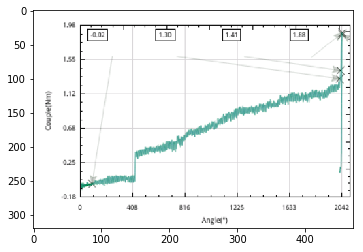

In [3]:
# Load data
img = load_cv_image('test_image.png')
print("Image size: " + str(img.shape))
plt.imshow(img)

The part that has more than 80 same x coordinate are : [(3687, 3862)]


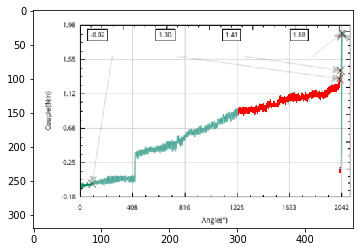

In [4]:
# image mask
color_range = [60, 160, 160, 210, 130, 200]
num_thr = 80
x_thr = 300
X, y = color_filter(img, color_range)
X_sortX, y_sortX = sort_X(X, y)
X_new, y_new = del_vert(X_sortX, y_sortX, num_thr)
X_new, y_new = del_start(X_new, y_new, x_thr)
img_mask = image_mask(img, X_new, y_new, color=np.array([255,0,0], dtype=np.uint8))
plt.imshow(img_mask)

Cross point is: (451.103, 113.502)


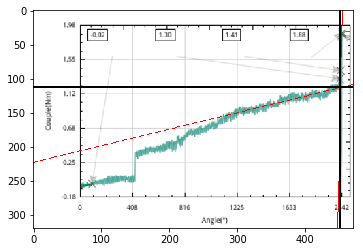

In [102]:
max_iter = 100000
dic_line_params = line_extraction_ransac(X_new, y_new, max_iter)
k1 = dic_line_params["k1"]
b1 = dic_line_params["b1"]
k2 = dic_line_params["k2"]
b2 = dic_line_params["b2"]
x_cross = dic_line_params["x_cross"]
y_cross = dic_line_params["y_cross"]
img_ransac = img.copy()
img_ransac = draw_line_cv(img_ransac, k1, b1,line_width=1)
img_ransac = draw_line_cv(img_ransac, k2, b2,line_width=1)

print("Cross point is: ({}, {})".format(float('%0.3f'%x_cross), float('%0.3f'%y_cross)))

cv2.line(img_ransac, (int(x_cross), 0), (int(x_cross), img_ransac.shape[0]), (0,0,0), 2)
cv2.line(img_ransac, (0, int(y_cross)), (img_ransac.shape[1], int(y_cross)), (0,0,0), 2)
plt.imshow(img_ransac)

In [148]:
def find_scale(dic_line_params, dic_corners, dic_markers, dic_coor):
    dic_scale = {}
    pt_orig = dic_corners["left_down"]
    mark_x = dic_markers["mark_X"]
    mark_y = dic_markers["mark_y"]
    dist_x = mark_x - pt_orig[0]
    dist_y = (pt_orig[1] - mark_y) / 2
    x_value = []
    y_value = []
    x_coor = dic_coor["CoorX"]
    y_coor = dic_coor["CoorY"]
    for i in range(len(x_coor)-1):
        x_value.append(float(x_coor[i+1]) - float(x_coor[i]))
    for i in range(len(y_coor)-1):
        y_value.append(round(float(y_coor[i+1]) - float(y_coor[i]), 2))
    x_scale = Counter(x_value).most_common(1)[0][0] / dist_x
    y_scale = Counter(y_value).most_common(1)[0][0] / dist_y
    dic_scale["scale_x"] = x_scale
    dic_scale["scale_y"] = y_scale
    return dic_scale

In [147]:
dic_scale = find_scale(dic_line_params, dic_corners, dic_markers, dic_coor)

408.0
5.230769230769231
0.008514851485148515


In [157]:
dic_corners = find_corner(img)
dic_markers = find_mark(img,dic_corners)

pt_orig = dic_corners["left_down"]
mark_x = dic_markers["mark_X"]
mark_y = dic_markers["mark_y"]
dist_x = mark_x - pt_orig[0]
dist_y = (pt_orig[1] - mark_y) / 2

print("The origin of coordinate is: {}".format(pt_orig))
print("The firs marker in X axis is: {}".format((mark_x, pt_orig[1])))
print("The second marker in y axis is: {}".format((pt_orig[0], mark_y)))
print("The distance of every tick mark in X axis is {} pixel".format(dist_x))
print("The distance of every tick mark in y axis is {} pixel".format(dist_y))

dic_coor = find_coordinate(img, dic_corners, dic_markers)
print("The scale in x axis is: {}".format(dic_coor["CoorX"]))
print("The scale in y axis is: {}".format(dic_coor["CoorY"]))

dic_scale = find_scale(dic_line_params, dic_corners, dic_markers, dic_coor)
scale_x = dic_scale["scale_x"]
scale_y = dic_scale["scale_y"]
print("The x scale is {}/pixel".format(float('%0.3f'%scale_x)))
print("The y scale is {}/pixel".format(float('%0.5f'%scale_y)))


pt1_x = (x_cross - pt_orig[0]) * scale_x
pt1_y = (pt_orig[1] - y_cross) * scale_y
pt2_y = float(find_peak(img, dic_corners))
y_pix = int(pt_orig[1] - (pt2_y - float(dic_coor["CoorY"][0])) / scale_y)
pt2_x = (y_pix - b2)/k2 - pt_orig[0]
print("The first point is: ({}, {})".format(float('%0.3f'%pt1_x), float('%0.3f'%pt1_y)))
print("The second point is: ({}, {})".format(float('%0.3f'%pt2_x), float('%0.3f'%pt2_y)))

The origin of coordinate is: (69, 274)
The firs marker in X axis is: (147, 274)
The second marker in y axis is: (69, 173)
The distance of every tick mark in X axis is 78 pixel
The distance of every tick mark in y axis is 50.5 pixel
The scale in x axis is: ['0', '408', '816', '1225', '1633', '2042']
The scale in y axis is: ['-0.18', '0.25', '0.68', '1.12', '1.55', '1.98']
The x scale is 5.231/pixel
The y scale is 0.00851/pixel
32
The first point is: (1998.694, 0.379)
The second point is: (453.295, 1.88)


In [156]:
pt1_x = (x_cross - pt_orig[0]) * scale_x
pt1_y = (y_cross - pt_orig[0]) * scale_y
pt2_y = float(find_peak(img, dic_corners))
y_pix = int(pt_orig[1] - (pt2_y - float(dic_coor["CoorY"][0])) / scale_y)
print(y_pix)

NameError: name 'scale_x' is not defined